**NLP - Extracting product info from texts with LLM**

- *Karina Tiurina*
- *Salveen Dutt*
- *Patryk Prusak*

Comparison of various NLP models in the task of classifying reviews to specific product types extracting product keywords and attributes.


Metrics used:

1. Smith-Waterman
2. Needleman-Wunsch
3. Levenshtein Distance
5. Bert Score
6. Hamming Distance

Models used:

1. "Qwen/Qwen2.5-7B-Instruct"
2. "google/gemma-2-2b-it"
3. "google/gemma-2-9b-it"
4. "meta-llama/Llama-3.1-8B-Instruct"
5. "meta-llama/Llama-3.2-3B-Instruct"
6. "arcee-ai/Arcee-Spark"
7. "mistralai/Ministral-8B-Instruct-2410"

#### Inputs & Consts

In [ ]:
import json
import bert_score
from transformers import pipeline
import torch
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import Levenshtein

sns.set_theme(palette="cubehelix")

c:\Users\prusak.patryk\Documents\Repos\nlp-labs\.venv2\Lib\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


#### Define data

In [2]:
with open("products.json", "r") as file:
    products = json.load(file)

#### Comparison metrics

In [3]:
def extract_information(product):
    product_category = product["product_category"]
    if "type" in product_category:
        product_category = product_category["type"]
    product_attributes = product["product_attributes"]
    other_keywords = product["other_keywords"]
    return product_category, product_attributes, other_keywords


def extract_and_concat_data(product):
    product_category, product_attributes, other_keywords = extract_information(product)
    return (
        product_category
        + " "
        + " ".join(product_attributes)
        + " "
        + " ".join(other_keywords)
    )

In [ ]:
def hamming_distance(llm_response, original_data):
    original_data_whole = extract_and_concat_data(original_data)
    llm_response_whole = extract_and_concat_data(llm_response)

    # calculate hamming distance
    hamming_distance = 0
    for ch1, ch2 in zip(original_data_whole, llm_response_whole):
        if ch1 != ch2:
            hamming_distance += 1
    hamming_distance += abs(len(original_data_whole) - len(llm_response_whole))
    return hamming_distance


def levenshtein_distance(llm_response, original_data):
    original_data_whole = extract_and_concat_data(original_data)
    llm_response_whole = extract_and_concat_data(llm_response)

    return Levenshtein.distance(original_data_whole, llm_response_whole)


def bert_metric(llm_response, original_data):
    original_data_whole = extract_and_concat_data(original_data)
    llm_response_whole = extract_and_concat_data(llm_response)

    P, R, F1 = bert_score.score(
        [llm_response_whole], [original_data_whole], lang="en", verbose=False
    )
    return F1.item()


def jaccard_distance(llm_response, original_data):
    original_data_whole = extract_and_concat_data(original_data)
    llm_response_whole = extract_and_concat_data(llm_response)

    return 1 - len(
        set(original_data_whole).intersection(set(llm_response_whole))
    ) / len(set(original_data_whole).union(set(llm_response_whole)))

#### Execution

In [5]:
# define prompt template
prompt_template = """
You are an assistant, helping in understanding of reviews. Carefully read the review:
{content}

Return json format with the following JSON schema:

{{
        "product_category": {{
            "type": "string",
            "enum": ["Electric bicycle", "Refrigirator", "The Blocks", "Others"]
        }},
        "product_attributes": {{
            "type": "array",
            "items": {{
                "type": "string"
            }}
        }},
        "other_keywords": {{
            "type": "array",
            "items": {{
                "type": "string"
            }}
        }},

}}
"""

In [ ]:
similarity_metrics = [
    hamming_distance,
    levenshtein_distance,
    bert_metric,
    jaccard_distance,
]

In [7]:
# Inspiration for model selection taken from https://huggingface.co/collections/open-llm-leaderboard/open-llm-leaderboard-best-models-652d6c7965a4619fb5c27a03

models = [
    "Qwen/Qwen2.5-7B-Instruct",
    "google/gemma-2-2b-it",
    "google/gemma-2-9b-it",
    "meta-llama/Llama-3.1-8B-Instruct",
    "meta-llama/Llama-3.2-3B-Instruct",
    "arcee-ai/Arcee-Spark",
    "mistralai/Ministral-8B-Instruct-2410",
]

In [8]:
responses = []
nlp = None

In [9]:
for model in models:
    try:
        print(f"Generating responses for reviews using {model}...")
        # load in 4bit greatly reduces the memory usage
        nlp = pipeline(
            "text-generation",
            model=model,
            model_kwargs={
                "torch_dtype": torch.bfloat16,
                "quantization_config": {
                    "load_in_4bit": True,
                },
                "low_cpu_mem_usage": True,
            },
        )

    except Exception as e:
        print(f"Failed to load model {model}, error: {e}")
        continue
    for productType in products["products"].keys():

        for review in products["products"][productType]["reviews"]:
            try:
                reviews_content = review["review_content"]

                prompt = prompt_template.format(content=reviews_content)
                messages = [
                    {"role": "user", "content": prompt},
                ]
                outputs = nlp(messages, max_new_tokens=256)
                responses.append(
                    [outputs[0]["generated_text"][1]["content"], review, model]
                )

            except Exception as e:
                print(
                    f"Failed to generate response for {productType} review, error: {e}"
                )
                continue
    try:
        # the memory is probably freed up, but to be safe we delete the nlp object and empty the cache
        del nlp
        torch.cuda.empty_cache()
    except Exception as e:
        print(f"Failed to delete nlp object, error: {e}")
        continue

Generating responses for reviews using Qwen/Qwen2.5-7B-Instruct...


Loading checkpoint shards: 100%|██████████| 4/4 [00:25<00:00,  6.39s/it]


Generating responses for reviews using google/gemma-2-2b-it...


Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.46s/it]


Generating responses for reviews using google/gemma-2-9b-it...


Loading checkpoint shards: 100%|██████████| 4/4 [00:17<00:00,  4.32s/it]


Generating responses for reviews using meta-llama/Llama-3.1-8B-Instruct...


Loading checkpoint shards: 100%|██████████| 4/4 [00:14<00:00,  3.73s/it]
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Generating responses for reviews using meta-llama/Llama-3.2-3B-Instruct...


Loading checkpoint shards: 100%|██████████| 2/2 [00:12<00:00,  6.49s/it]
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Generating responses for reviews using arcee-ai/Arcee-Spark...


Loading checkpoint shards: 100%|██████████| 4/4 [00:13<00:00,  3.49s/it]


Generating responses for reviews using mistralai/Ministral-8B-Instruct-2410...


Loading checkpoint shards: 100%|██████████| 4/4 [00:14<00:00,  3.71s/it]
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad

In [10]:
with open("responses.pkl", "wb") as f:
    pickle.dump(responses, f)

#### Results

In [6]:
with open("responses.pkl", "rb") as f:
    responses = pickle.load(f)

In [10]:
scoreArr = []

In [ ]:
# Calculate all metrics for each response
for i, response in enumerate(responses):
    scoreArr.append([None for j in range(len(similarity_metrics))])
    try:
        llm_response = response[0]
        llm_response_split = llm_response.split("```")
        if len(llm_response_split) > 1:
            llm_response = json.loads(llm_response_split[1].replace("json", ""))
        else:
            llm_response = json.loads(llm_response_split[0].replace("json", ""))

        for metricIndex, metric in enumerate(similarity_metrics):
            scoreArr[-1][metricIndex] = metric(
                llm_response, response[1]["golden_answer"]
            )
    except Exception as e:
        print(f"Failed to calculate scores for response {i}, error: {e}")
        continue

In [12]:
for i, score in enumerate(scoreArr):
    responses[i] = responses[i] + score

In [15]:
columns = ["response", "review", "model"] + [
    metric.__name__ for metric in similarity_metrics
]
results_df = pd.DataFrame(responses, columns=columns)
results_df.to_csv("results.csv", index=False)

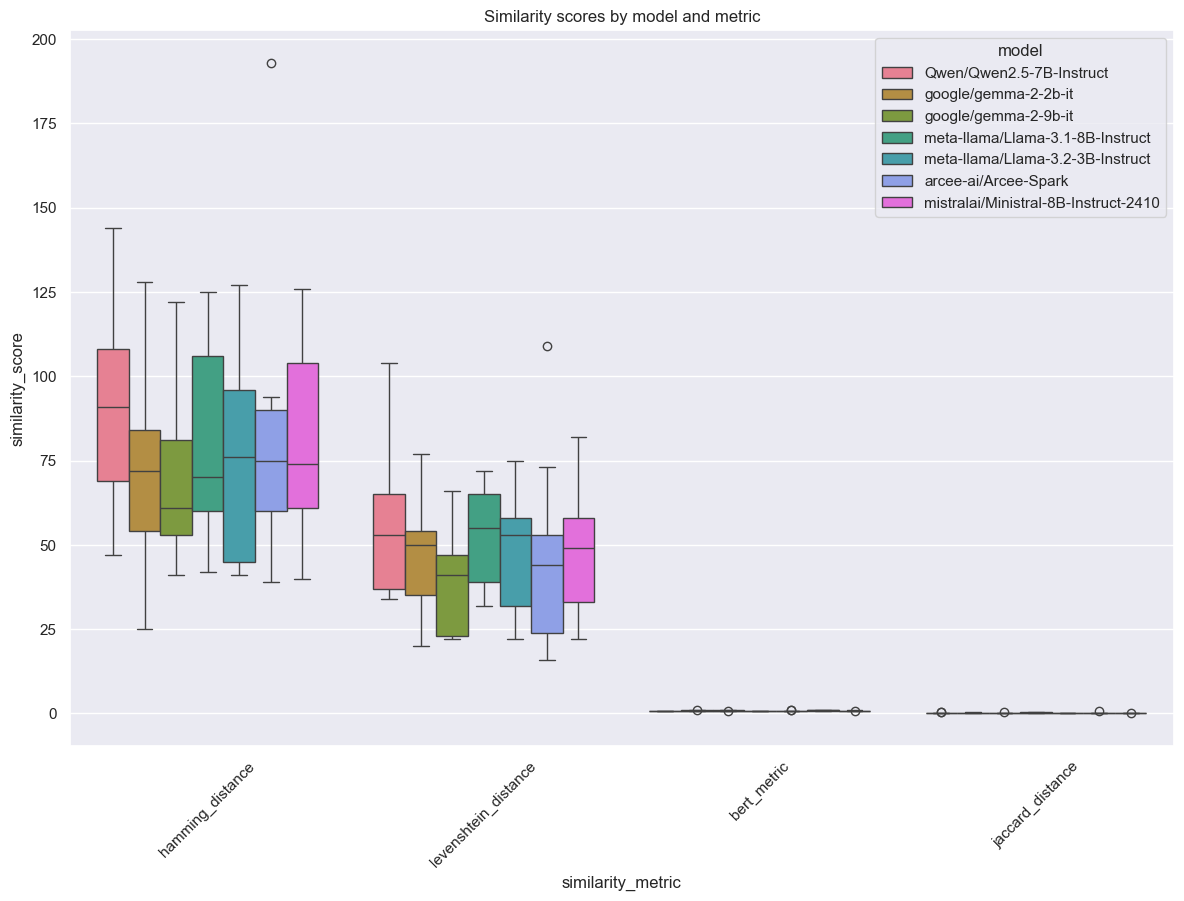

In [ ]:
results_transformed = results_df.melt(
    id_vars=["response", "review", "model"],
    var_name="similarity_metric",
    value_name="similarity_score",
)

results_transformed.to_csv("results_transformed.csv", index=False)
plt.figure(figsize=(12, 8))
sns.boxplot(
    data=results_transformed, x="similarity_metric", y="similarity_score", hue="model"
)
plt.tight_layout()
plt.title("Similarity scores by model and metric")
plt.xticks(rotation=45)
plt.show()

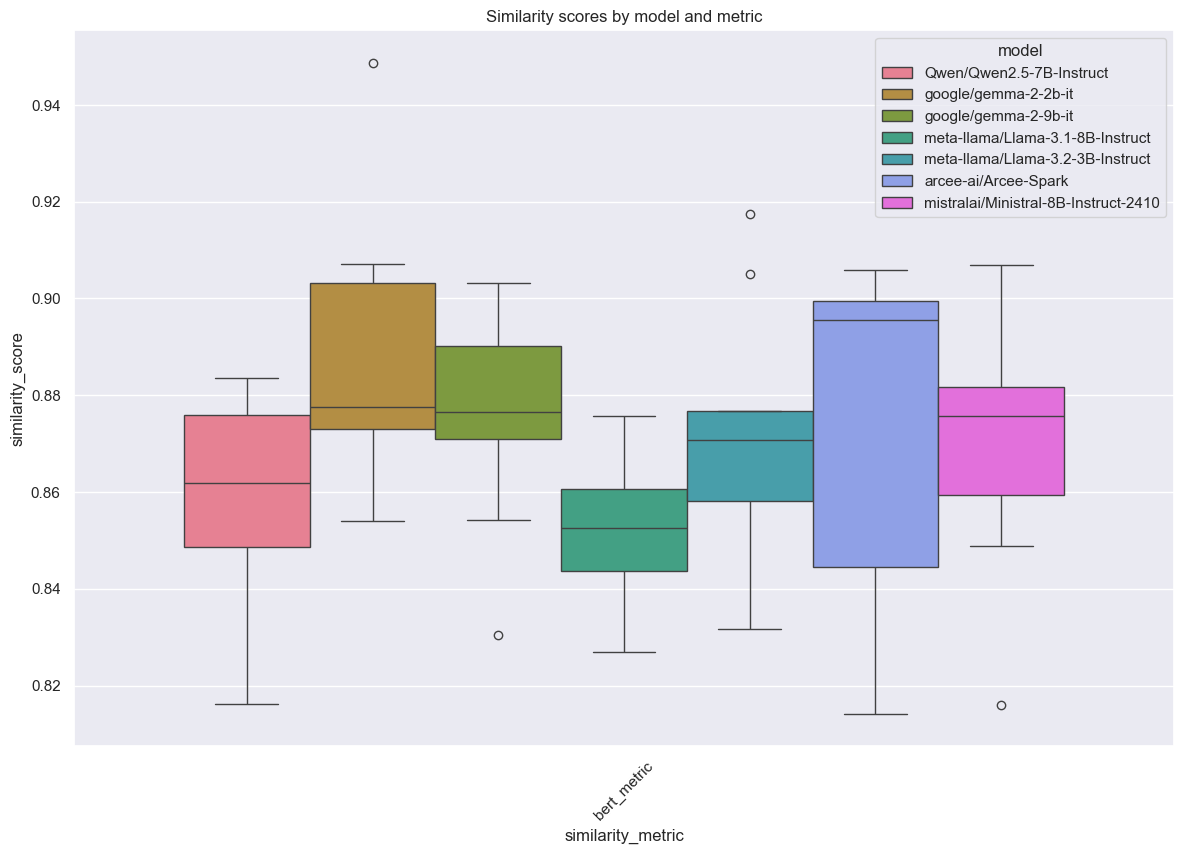

In [20]:
results_transformed.to_csv("results_transformed.csv", index=False)
plt.figure(figsize=(12, 8))
sns.boxplot(
    data=results_transformed.loc[
        results_transformed["similarity_metric"] == "bert_metric"
    ],
    x="similarity_metric",
    y="similarity_score",
    hue="model",
)
plt.tight_layout()
plt.title("Similarity scores by model and metric")
plt.xticks(rotation=45)
plt.show()

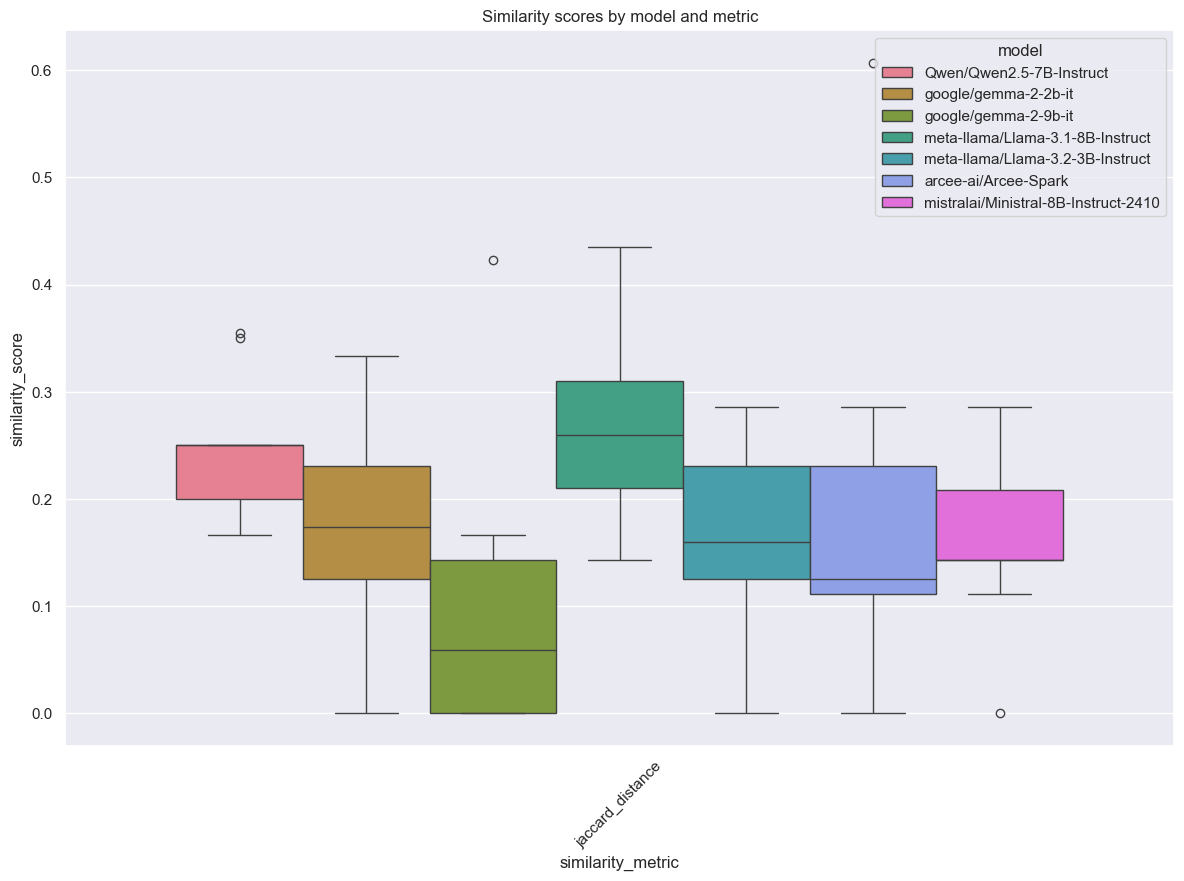

In [22]:
results_transformed.to_csv("results_transformed.csv", index=False)
plt.figure(figsize=(12, 8))
sns.boxplot(
    data=results_transformed.loc[
        results_transformed["similarity_metric"] == "jaccard_distance"
    ],
    x="similarity_metric",
    y="similarity_score",
    hue="model",
)
plt.tight_layout()
plt.title("Similarity scores by model and metric")
plt.xticks(rotation=45)
plt.show()

In [17]:
results_df.head(5)

,response,review,model,hamming_distance,levenshtein_distance,bert_metric,jaccard_distance
0,"```json\n{\n ""product_category"": ""Electric ...",{'review_content': 'The main thing: on the bat...,Qwen/Qwen2.5-7B-Instruct,91,65,0.875836,0.354839
1,"```json\n{\n ""product_category"": ""Elect...","{'review_content': 'Super contact, the bike lo...",Qwen/Qwen2.5-7B-Instruct,122,85,0.838157,0.166667
2,"```json\n{\n ""product_category"": {\n ...",{'review_content': 'The bike is great. We'll s...,Qwen/Qwen2.5-7B-Instruct,47,34,0.848581,0.350000
3,"```json\n{\n ""product_category"": {\n ...",{'review_content': 'Super refrigerator and act...,Qwen/Qwen2.5-7B-Instruct,90,53,0.816172,0.250000
4,"```json\n{\n ""product_category"": {\n ...",{'review_content': 'Very capauous refrigerator...,Qwen/Qwen2.5-7B-Instruct,144,104,0.868733,0.250000


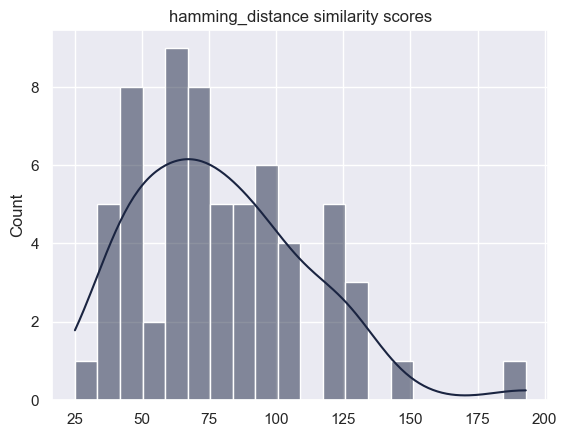

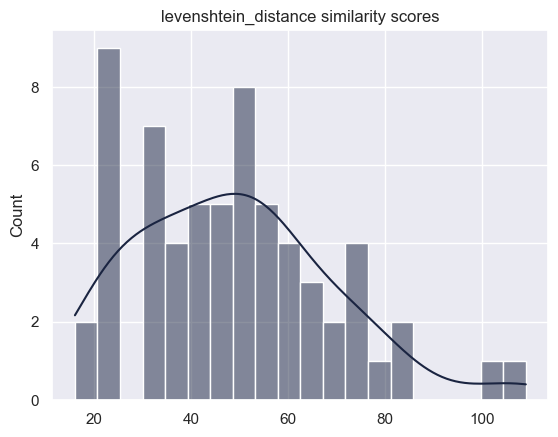

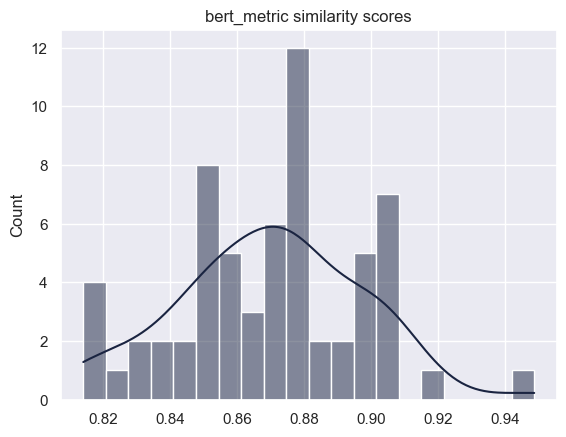

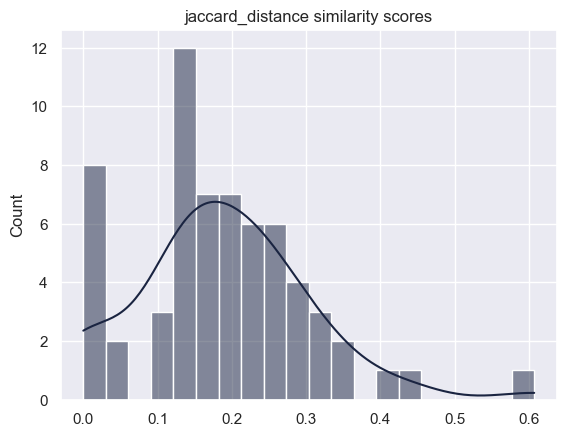

In [23]:
for i, metric in enumerate(similarity_metrics):
    try:
        scores = [score[i] for score in scoreArr]
        sns.histplot(scores, kde=True, bins=20)
        plt.title(f"{metric.__name__} similarity scores")
        plt.show()
    except:
        continue